In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup

In [ ]:
# colab pro 더 빠른 GPU 사용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  8 07:46:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# colab pro 추가 메모리
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import re
import numpy as np
import pandas as pd
import time

#from wordcloud import WordCloud
#from matplotlib import pyplot as plt

#import gensim
#import string
#from gensim import corpora
#from gensim.test.utils import common_texts
#from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import multiprocessing
num_cores = multiprocessing.cpu_count()

## 확인 필요. 문제 없으면 지울 수 있음. ##
# Check versions to ensure that there are no compatability issues:
python_version = !python --version
print("Python Version: ", python_version)
print("Current Directory: ", os.getcwd())
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)

Python Version:  ['Python 3.7.12']
Current Directory:  /content
Numpy version:  1.19.5
Pandas version:  1.1.5


## Training Sections
Full_Text로 section 2('_2')의 CEO's review/letter 데이터를 사용했다. 여기서는 DataFrame 으로 Full_Text 파일 리스트를 정렬시키고 데이터의 중복여부를 확인해줬다. 문서의 수는 3091개. 

In [ ]:
train_list = os.listdir("/content/drive/MyDrive/Aiffel_Hackathon/Data/training_sections")
len(train_list)
train_df = pd.DataFrame(train_list, columns=['Original_Filename'])
train_df['Original_Filename'] = train_df['Original_Filename'].str.replace('.txt', '')
train_df[['Document', 'Middle', 'Section']] = train_df['Original_Filename'].str.split('_').tolist()

train_df.head()


3091

,Original_Filename,Document,Middle,Section
0,15783_819108_2,15783,819108,2
1,15782_819091_2,15782,819091,2
2,15787_819176_2,15787,819176,2
3,15816_820156_2,15816,820156,2
4,15817_820129_2,15817,820129,2


In [ ]:
# section 2 확인 
train_df.loc[train_df['Section'] != "2"]

,Original_Filename,Document,Middle,Section


## Full_Text Data 읽어와서 DataFrame 에 붙이기
Txt 에 있는 Full_Text 를 하나씩 가져와서 DataFrame에 추가시켜 주었다. 

In [ ]:
%cd /content/drive/MyDrive/Aiffel_Hackathon/Data/training_sections

/content/drive/MyDrive/Aiffel_Hackathon/Data/training_sections


In [ ]:
training_file_list = [x + str(".txt") for x in train_df['Original_Filename']]
len(training_file_list)

3091

In [ ]:
file_path = '/content/drive/MyDrive/Aiffel_Hackathon/Data/training_sections/'

sentence_list = [] 
for i in training_file_list: 
  with open(file_path + i, "r", encoding='utf-8') as f: 
    temp_str = '' 
    for line in f: 
      line = line.replace('\n', ' ') 
      temp_str += line 
    sentence_list.append(temp_str)

In [ ]:
len(sentence_list)
sentence_list[10]

3091

' 5 Plc Annual Report and Financial Statements 201 1 Review of the business Governance Financial Statements Other information k Our focus during the period has been on strengthening  our market leading position by continuing to deliver  outstanding service and excellent value, high quality  products to our customers. We further upgraded and  expanded our store estate, continued the evolution of  the\xa0Topps Tiles offer and supported this with new  marketing initiatives in-store, on television and online.  In\xa0addition, we made some significant infrastructure  investments across the business, which will benefit  our\xa0future performance. Prudent management of all costs remained a key focus.  In addition we also reviewed a number of our retail  processes to both further improve our proposition to  customers and enhance financial performance. The economic environment has continued to be  challenging and, in particular, we saw a slowing in  customer numbers during the second half of ou

In [ ]:
train_df['Full_Text'] = sentence_list
train_df.head()

,Original_Filename,Document,Middle,Section,Full_Text
0,15783_819108_2,15783,819108,2,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...
1,15782_819091_2,15782,819091,2,Chief executive Officer’s statement The Compa...
2,15787_819176_2,15787,819176,2,page 6 Toledo Mining Corporation plc Annual R...
3,15816_820156_2,15816,820156,2,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...
4,15817_820129_2,15817,820129,2,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...


In [ ]:
# 중복 확인 
print('원본파일 개수: ', len(train_df))
train_df.drop_duplicates(subset=['Full_Text'], keep='first', inplace=True)
train_df.drop_duplicates(subset=['Original_Filename'], keep='first', inplace=True)
print('중복 제거후 원본파일 개수: ', len(train_df))

원본파일 개수:  3091
중복 제거후 원본파일 개수:  3081


In [ ]:
# setting index
train_df.set_index('Original_Filename', inplace=True)

In [ ]:
train_df1 = train_df[['Full_Text']].copy()

In [ ]:
print(len(train_df1))
train_df1.head()

3081


,Full_Text
Original_Filename,
15783_819108_2,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...
15782_819091_2,Chief executive Officer’s statement The Compa...
15787_819176_2,page 6 Toledo Mining Corporation plc Annual R...
15816_820156_2,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...
15819_820208_2,REVIEW 2005 CHIEF EXECUTIVE’S STATEMENT TOMKI...


## Full_Text Length Review
Full_Text의 길이분포를 보고 단어의 숫자가 500개 이하 또는 4000개 이상인 문서는 삭제해줬다. 문서의 총 숫자는 2739개. 

In [ ]:
train_df2 = train_df1.reset_index()
train_df2.head()

,Original_Filename,Full_Text
0,15783_819108_2,CHIEF EXECUTIVE OFFICER’S STATEMENT The Bero...
1,15782_819091_2,Chief executive Officer’s statement The Compa...
2,15787_819176_2,page 6 Toledo Mining Corporation plc Annual R...
3,15816_820156_2,3 CHIEF EXECUTIVE’S STATEMENT TOMKINS PLC REP...
4,15819_820208_2,REVIEW 2005 CHIEF EXECUTIVE’S STATEMENT TOMKI...


In [ ]:
for i, doc in enumerate(train_df2['Full_Text']):
  train_df2.loc[i, 'FT_Len'] = len(doc.split())

In [ ]:
len(train_df2)

3081

count     3081.000000
mean      2030.727037
std       1466.879672
min          0.000000
25%       1130.000000
50%       1706.000000
75%       2538.000000
max      21742.000000
Name: FT_Len, dtype: float64

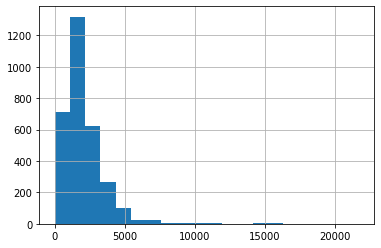

In [ ]:
train_df2['FT_Len'].describe()
train_df2['FT_Len'].hist(bins=20)

In [ ]:
# check outliers (short or no data)
train_df2.loc[train_df2['FT_Len'] < 50]

,Original_Filename,Full_Text,FT_Len
421,18690_384070_2,Hilton Food Group plc Annual report and fina...,34.0
688,20891_55666_2,STATEMENT FROM THE CEO EMERGING FROM THE DOW...,13.0
1013,7497_388306_2,,0.0
1238,9112_479129_2,04 Kentz Corporation Limited Annual Report an...,47.0
1497,11274_591214_2,4 Northern Foods plc Annual report and accoun...,16.0
1767,14018_738551_2,,0.0
2032,846_45854_2,,0.0
2161,1810_93107_2, o       o  o...,43.0
2224,2363_131046_2,,0.0
2943,7018_357873_2,STRA TEGIC REVIEW “Halma made good progress ...,38.0


In [ ]:
# check outliers (long text)
over4000 = train_df2.loc[train_df2['FT_Len'] > 4000].copy()
print(len(over4000))
print("ratio: ", len(over4000)/len(train_df2['FT_Len'])*100)

221
ratio:  7.172995780590717


In [ ]:
over500 = 500 < train_df2['FT_Len']
less4000 = 4000 > train_df2['FT_Len']
train_df3 = train_df2.loc[over500 & less4000].copy()
len(train_df3)

2730

## Full_Text 전처리

In [ ]:
def preprocessing(sentence): 
  sentence = sentence.lower()
  sentence = re.sub("[$]", "dollar ", sentence)
  sentence = re.sub("[£]", "pound ", sentence)
  sentence = re.sub("[%]", " percent", sentence)
  sentence = re.sub(r"[^a-zA-Z0-9?!.,’-]", ' ', sentence)
  sentence = re.sub(r"([?!])", r" \1 ", sentence)
  sentence = re.sub(r'([a-z])(?=[.,])', r'\1 ', sentence)
  sentence = re.sub(r"\s+", " ", sentence)
  return sentence

In [ ]:
# full text testing
pro_sample1 = preprocessing(train_df3['Full_Text'][0])
pro_sample1

' chief executive officer’s statement the berong nickel mine has been in operation for just over one year and has successfully made shipments of laterite ore to chinese and australian customers . for the full year april 1 2007 through march 31 2008, approximately 467,278 tonnes of ore at an average grade of 1.52 percent ni was shipped . from the commencement of trial metallurgical shipments in january 2007 until the end of june 2008, approximately 815,000 tonnes of ore at an average grade of 1.52 percent ni was shipped into the market place . many of the temporary facilities put into place to capture the benefits of historically high nickel prices have been replaced by permanent facilities . these include the office complex , accommodation facilities , the laboratory , the heavy equipment workshops and environmental structures . the dangla road which was planned for construction for 2007 was deferred until 2008 due to the delays in gaining all the necessary approvals . still under eval

In [ ]:
unclean_full_text = list(train_df3['Full_Text'])
clean_full_text =[]
for item in unclean_full_text: 
  sentences = preprocessing(item)
  clean_full_text.append(sentences)

In [ ]:
# Replace the columns with the clean data
train_df3['Full_Text'] = clean_full_text
# sample 
print(train_df3['Full_Text'][0])

 chief executive officer’s statement the berong nickel mine has been in operation for just over one year and has successfully made shipments of laterite ore to chinese and australian customers . for the full year april 1 2007 through march 31 2008, approximately 467,278 tonnes of ore at an average grade of 1.52 percent ni was shipped . from the commencement of trial metallurgical shipments in january 2007 until the end of june 2008, approximately 815,000 tonnes of ore at an average grade of 1.52 percent ni was shipped into the market place . many of the temporary facilities put into place to capture the benefits of historically high nickel prices have been replaced by permanent facilities . these include the office complex , accommodation facilities , the laboratory , the heavy equipment workshops and environmental structures . the dangla road which was planned for construction for 2007 was deferred until 2008 due to the delays in gaining all the necessary approvals . still under evalu

In [ ]:
train_df3.head()

,Original_Filename,Full_Text,FT_Len
0,15783_819108_2,chief executive officer’s statement the beron...,1147.0
1,15782_819091_2,chief executive officer’s statement the compa...,882.0
2,15787_819176_2,page 6 toledo mining corporation plc annual r...,2203.0
3,15816_820156_2,3 chief executive’s statement tomkins plc rep...,2032.0
4,15819_820208_2,review 2005 chief executive’s statement tomki...,505.0


## Label 만들기 

### 필요한 모듈 설치하기 

In [ ]:
! pip install sumy
! pip install nltk

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer
import pandas as pd
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Edmundson Summarizer (파이썬 내장함수 사용)
4가지 method가 있는데 여기서는 cue_method만 사용했다. 

* cue_method:These are the key words that are manually selected and are highly correlated with the importance of sentences. 파이썬 내장 라이브러리에서는 bonus, stigma 단어로 rating을 정한다. 
Cue weight = Σ (Cue weight of each word in sentence)  
  * Bonus words   
These are the words pointing towards the important sentences. These may include superlatives ,adverbs etc.   

  * Stigma words   
These are the words that have negative addect on the sentence importance. It includes anaphoric expressions, belittling expressions, etc.(We may expect the machine to treat them important but they are not really.)    

In [ ]:
print ("--EdmundsonSummarizer--")    

e_summarizer = EdmundsonSummarizer(cue_weight=1.0, key_weight=0,
            title_weight=0, location_weight=0) 

words1 = ("acquisition", "risk", "purchase", "reorganisation", "hedge", "investment", "asset", "sell", "related", "affiliate", "cash", "debt", "increase", "goodwill", "buy", "merge", "decrease", "loan", "restructure")
e_summarizer.bonus_words = words1
   
words2 = ("chief executive", "annual report", "letter")
e_summarizer.stigma_words = words2
    
# 'revenue', 'operating' 는 중요한 단어이므로 stop words에서 제외시켰다. 
words3 = ('the','.', 'and', ',', 'of', 'to', 'in', 'a', 'our', 'we', 'for', 'with', 'is', 'year', 'on', 'percent', 'as', 'pound', 'this', 'have', 'are', 'by', 'has', 'business'
'that', 'from', 'new', 'at', 'will', 'group', 'market', 'growth', 'which', 'was', 'an', 'be', 'million', 'been', 'report', 'its','sales', 'us', 'it', 
'customers', 'also', 'over', 'during', 'services', 'more', 'chief',  'these' , 'uk', 'products', 'development', 'all', 'annual', 'further', 
'through', 'well', 'markets', 'management', 'continue', 'strong', 'performance', 'review', 'continued', 'financial', 'their', 'were', 'product', 'plc', 'i', 
'now','strategy', 'increased', 'service', 'customer', 'into')
 
e_summarizer.null_words = words3 # 80 stopwords (평균적으로 1 문서에 3번 이상 등장하는 단어들)


--EdmundsonSummarizer--


In [ ]:
sen_count = 12

In [ ]:
train_df4 = train_df3.reset_index(drop=True)
train_df4.head()

,Original_Filename,Full_Text,FT_Len
0,15783_819108_2,chief executive officer’s statement the beron...,1147.0
1,15782_819091_2,chief executive officer’s statement the compa...,882.0
2,15787_819176_2,page 6 toledo mining corporation plc annual r...,2203.0
3,15816_820156_2,3 chief executive’s statement tomkins plc rep...,2032.0
4,15819_820208_2,review 2005 chief executive’s statement tomki...,505.0


In [ ]:
for i, doc in enumerate(train_df4['Full_Text']): 
  p_text = PlaintextParser.from_string(doc, Tokenizer("english")) # parsing
  
  new_doc = ""
  for sentence in e_summarizer(p_text.document, sen_count): 
    new_doc += sentence._text # type is str, thus, concatenating with +

  train_df4.loc[i, 'Summary'] = new_doc

In [ ]:
train_df4.head()

,Original_Filename,Full_Text,FT_Len,Summary
0,15783_819108_2,chief executive officer’s statement the beron...,1147.0,chief executive officer’s statement the berong...
1,15782_819091_2,chief executive officer’s statement the compa...,882.0,chief executive officer’s statement the compan...
2,15787_819176_2,page 6 toledo mining corporation plc annual r...,2203.0,page 6 toledo mining corporation plc annual re...
3,15816_820156_2,3 chief executive’s statement tomkins plc rep...,2032.0,we continued our investment in manufacturing e...
4,15819_820208_2,review 2005 chief executive’s statement tomki...,505.0,review 2005 chief executive’s statement tomkin...


### Summary Text 길이 분석 및 내용 샘플 테스트 

In [ ]:
for i, doc in enumerate(train_df4['Summary']): 
  train_df4.loc[i, 'Summary_Len']= len(doc.split())


count    2730.000000
mean      432.930769
std       135.524634
min       122.000000
25%       348.250000
50%       405.000000
75%       488.000000
max      1938.000000
Name: Summary_Len, dtype: float64

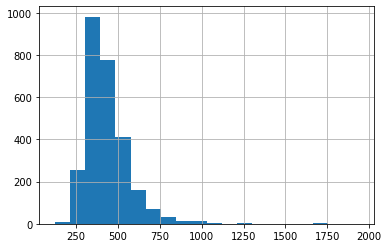

In [ ]:
train_df4['Summary_Len'].describe()
train_df4['Summary_Len'].hist(bins=20)

In [ ]:
# 데이터의 대부분이 띄어쓰기가 이상하고 문장의 구성이 비정상적이다. 그러므로 훈련데이터에서 삭제시킨다. 
over_1000 = train_df4.loc[train_df4['Summary_Len'] > 1000 ].copy()
over_1000

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
133,16827_867435_2,6 volga gas plc annual report and accounts 20...,3883.0,6 volga gas plc annual report and accounts 200...,1254.0
139,16836_867700_2,0 6 voller energy group plc a n n u a l r e p...,3425.0,0 6 voller energy group plc a n n u a l r e p ...,1156.0
140,16836_867699_2,0 4 voller energy group plc a n n u a l r e p...,2679.0,0 4 voller energy group plc a n n u a l r e p ...,1938.0
143,16837_867718_2,voller energy group plc a n n u a l r e p o r...,2598.0,voller energy group plc a n n u a l r e p o r ...,1717.0
499,19544_726175_2,24564.04 - 30 march 2016 3 56 pm - proof 9 ch...,2202.0,24564.04 - 30 march 2016 3 56 pm - proof 9 chi...,1009.0
713,22409_190034_2,chief executive officer’s review significantl...,3578.0,clients seem to be happy and the asset class s...,1079.0
728,22719_214538_2,cpp is committed to providing a great service...,1507.0,cpp is committed to providing a great service ...,1552.0
881,25038_401236_2,14 15 ig group holdings plc 2014 annual repor...,2428.0,our binaries enable clients to trade with limi...,1241.0
1078,8660_449704_2,6 james fisher and sons plc chief executive’s...,3282.0,sustained organic growth represented 85 percen...,1635.0
1277,10585_558903_2,morse plc annual report 2007 8 chief executiv...,1564.0,morse plc annual report 2007 8 chief executive...,1024.0


In [ ]:
train_df5 = train_df4.loc[train_df4['Summary_Len'] < 1000].copy() 
len(train_df5)

2717

In [ ]:
over_500 = train_df5.loc[train_df5['Summary_Len'] > 500 ].copy()
over_500.reset_index(drop=True, inplace=True)
over_500

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,15816_820156_2,3 chief executive’s statement tomkins plc rep...,2032.0,we continued our investment in manufacturing e...,631.0
1,16027_830144_2,6 annual report and accounts 2011 chief execu...,559.0,6 annual report and accounts 2011 chief execut...,522.0
2,16032_830444_2,introduction although 2005 has been more chal...,3917.0,we faced two key challenges in 2005 integratin...,548.0
3,16053_831556_2,treatt plc annual report and financial statem...,1920.0,treatt plc annual report and financial stateme...,514.0
4,16120_833782_2,23401.04 28 july 2014 6 24 pm proof 8 chairma...,3456.0,this quantum leap in value is testament that o...,573.0
...,...,...,...,...,...
578,324_19904_2,advanced computer software group plc annual r...,1477.0,"we have created a strong , stable and cash gen...",571.0
579,334_20136_2,14 advanced medical solutions group plc annua...,1458.0,14 advanced medical solutions group plc annual...,510.0
580,335_20160_2,12 13 advanced medical solutions group plc an...,2230.0,12 13 advanced medical solutions group plc ann...,622.0
581,337_20210_2,strategic report continued 12 advanced medica...,1798.0,strategic report continued 12 advanced medical...,574.0


count     583.000000
mean     2210.497427
std       826.705005
min       559.000000
25%      1541.500000
50%      2163.000000
75%      2746.500000
max      3999.000000
Name: FT_Len, dtype: float64

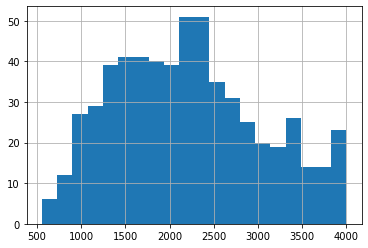

In [ ]:
over_500['FT_Len'].describe()
over_500['FT_Len'].hist(bins=20)

### Summa로 레이블 만들기
위에서 만든 레이블 중에서 길이가 너무 긴 레이블을 TexRank를 통해서 키워드 요약을 해준다. 

In [ ]:
!pip install summa

In [ ]:
from summa.summarizer import summarize

In [ ]:
for i, doc in enumerate(over_500['Full_Text']): 
  new_doc = summarize(doc, words=400)
  over_500.loc[i, 'TR_Summary'] = new_doc

In [ ]:
for i, doc in enumerate(over_500['TR_Summary']): 
  over_500.loc[i, 'TR_Summary_Len'] = len(doc.split())


count    583.000000
mean     400.773585
std       23.866543
min      214.000000
25%      388.000000
50%      400.000000
75%      413.000000
max      516.000000
Name: TR_Summary_Len, dtype: float64

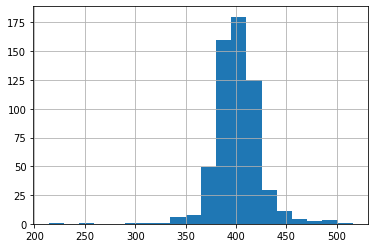

In [ ]:
over_500['TR_Summary_Len'].describe()
over_500['TR_Summary_Len'].hist(bins=20)

In [ ]:
over_500.loc[over_500['TR_Summary_Len'] > 500 ]

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len,TR_Summary,TR_Summary_Len
448,3402_183758_2,companies that seek to communicate in today’s...,1450.0,companies that seek to communicate in today’s ...,643.0,"christopher satterthwaite , group chief execut...",516.0


In [ ]:
print(over_500['TR_Summary'][5])

tt electronics plc annual report 2003 9 we continue to respond rapidly to the changing demands of our customers for new technical developments , improving factory ef ciencies and moving more production to our factories in low labour cost areas .
the group has a global presence servicing major customers including the majority of the world’s major original equipment manufacturers oem in the automotive , telecom , computer and general industrial markets working with them on the development of new product lines .the group has built up a reputation amongst this blue chip customer base as being innovative , cost effective and a high quality manufacturer of a range of electronic and electrical products .
sales of our electronic manufacturing services business were also reduced following the decision by one large customer to take assembly work back in house .there was little sign of a recovery in the telecom data infrastructure or computer markets during the year but currently there is general

In [ ]:
over_500.drop(['Summary', 'Summary_Len'], axis=1, inplace=True)
over_500.rename(columns={'TR_Summary' : 'Summary', 'TR_Summary_Len': 'Summary_Len'}, inplace=True)
over_500.head()

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,15816_820156_2,3 chief executive’s statement tomkins plc rep...,2032.0,we have previously outlined our plans to devel...,407.0
1,16027_830144_2,6 annual report and accounts 2011 chief execu...,559.0,6 annual report and accounts 2011 chief execut...,402.0
2,16032_830444_2,introduction although 2005 has been more chal...,3917.0,introduction although 2005 has been more chall...,408.0
3,16053_831556_2,treatt plc annual report and financial statem...,1920.0,"with greater focus , clarity and cost control ...",419.0
4,16120_833782_2,23401.04 28 july 2014 6 24 pm proof 8 chairma...,3456.0,"summarising the key facts relating to vic , be...",326.0


### Summa 로 만든 label을 train_df4에 replace 하기 

In [ ]:
train_df5 = train_df4.loc[train_df4['Summary_Len'] <= 500].copy()
len(train_df5)

2134

In [ ]:
len(over_500) + len(train_df5)

2717

In [ ]:
train_df6 = pd.concat([train_df5, over_500], ignore_index=True)
len(train_df6)

2717

In [ ]:
train_df6.head()

,Original_Filename,Full_Text,FT_Len,Summary,Summary_Len
0,15783_819108_2,chief executive officer’s statement the beron...,1147.0,chief executive officer’s statement the berong...,305.0
1,15782_819091_2,chief executive officer’s statement the compa...,882.0,chief executive officer’s statement the compan...,319.0
2,15787_819176_2,page 6 toledo mining corporation plc annual r...,2203.0,page 6 toledo mining corporation plc annual re...,413.0
3,15819_820208_2,review 2005 chief executive’s statement tomki...,505.0,review 2005 chief executive’s statement tomkin...,352.0
4,15842_821001_2,7 plc annual report and financial statements ...,1948.0,7 plc annual report and financial statements 2...,352.0


count    2717.00000
mean      384.59735
std        59.34245
min       122.00000
25%       347.00000
50%       390.00000
75%       422.00000
max       516.00000
Name: Summary_Len, dtype: float64

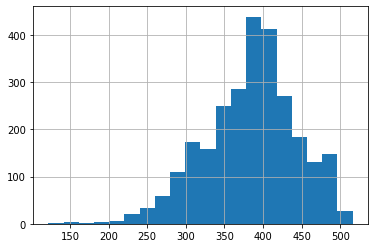

In [ ]:
train_df6['Summary_Len'].describe()
train_df6['Summary_Len'].hist(bins=20)

In [ ]:
train_df6.to_csv('/content/drive/MyDrive/Aiffel_Hackathon/Data/train_data_newlabel.csv')